In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt

## Features selection and data cleaning.  (preprocessing)

In [2]:
def clean_price_format(price):
    if price.find(","):
        formatted_price = price.replace(",",".")
    return formatted_price

In [3]:
df = pd.read_csv("datasets/tennis-point.csv", sep=";")

#prices format cleaning
df['VecchioPrezzo'] = df['VecchioPrezzo'].apply(clean_price_format) 
df["Prezzo"] = df["Prezzo"].apply(clean_price_format)
df = df.astype({'VecchioPrezzo':'float'})
df = df.astype({'Prezzo':'float'})
df = df[df["VecchioPrezzo"] > 0]

#istanciating target and values dataframes
data_target = df[['Prezzo']].copy() #regression target column
data_values = df[['Marca', 'Modello','Sesso', 'ColoreUno','VecchioPrezzo']].copy() #selection of training features

#Turning categorical features into numerical data

transformer = make_column_transformer((OneHotEncoder(), ['Marca', 'Modello','Sesso','ColoreUno']), remainder='passthrough')
transformed = transformer.fit_transform(data_values, data_target)
transformed = transformed.toarray()
feature_names = np.array(transformer.get_feature_names_out())

transformed_df = pd.DataFrame(transformed, columns=feature_names)
display(transformed_df)
X_data = transformed
Y_data = np.array(data_target.values.tolist())

,onehotencoder__Marca_Babolat,onehotencoder__Marca_Black Crown,onehotencoder__Marca_Bullpadel,onehotencoder__Marca_Cartri,onehotencoder__Marca_Drop Shot,onehotencoder__Marca_Dunlop,onehotencoder__Marca_Fila,onehotencoder__Marca_HEAD,onehotencoder__Marca_Joma,onehotencoder__Marca_NOX,...,onehotencoder__ColoreUno_multicolore,onehotencoder__ColoreUno_nero,onehotencoder__ColoreUno_oro,onehotencoder__ColoreUno_rosa,onehotencoder__ColoreUno_rosso,onehotencoder__ColoreUno_rosso chiaro,onehotencoder__ColoreUno_turchese,onehotencoder__ColoreUno_verde,onehotencoder__ColoreUno_nan,remainder__VecchioPrezzo
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.00
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180.00
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,340.00
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,340.00
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,320.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,340.00
359,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,250.00
360,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,340.00
361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.00


## Cross-validation and GridSearch of the models

In [19]:
#Decision tree
print("decision tree regressor: ")
tree_rg_cv = DecisionTreeRegressor(random_state=0)
neg_mae = cross_val_score(tree_rg_cv, X_data, Y_data, cv=5, scoring='neg_mean_absolute_percentage_error')
print("5-fold cross-validation with the following negative mean absolute errors: ")
print(neg_mae)
print(f"the mean of the negative mean absolute errors is: {neg_mae.mean()}")
print("\n")

#Linear regression (ridge) gridsearchCV with 5-fold cross-validation
print("ridge linear regressor: ")
linear_ridge = Ridge()
alphas = np.arange(0.1,5,0.1)
parameters = {'alpha': alphas}
ridge_reg= GridSearchCV(linear_ridge, parameters, scoring='neg_mean_absolute_error',cv=5)
ridge_reg.fit(X_data,Y_data)
print(ridge_reg.best_estimator_)
best_ridge_rg = ridge_reg.best_estimator_
neg_mae = cross_val_score(best_ridge_rg, X_data, Y_data, cv=5, scoring='neg_mean_absolute_percentage_error')
print("5-fold cross-validation on the best ridge regressor with the following negative mean absolute errors: ")
print(neg_mae)
print(f"mean of the negative mean absolute errors: {neg_mae.mean()}")
print("\n")

decision tree regressor: 
5-fold cross-validation with the following negative mean absolute errors: 
[-0.1265666  -0.17778224 -0.18285065 -0.0859099  -0.07612951]
the mean of the negative mean absolute errors is: -0.12984777961698007


ridge linear regressor: 
Ridge(alpha=0.2)
5-fold cross-validation on the best ridge regressor with the following negative mean absolute errors: 
[-0.17979743 -0.15681856 -0.17343545 -0.11434734 -0.10052699]
mean of the negative mean absolute errors: -0.1449851514622295




In [36]:
#Random Forest regressor
print("Random Forest regressor: ")
rf_params = { 
    'n_estimators': [10, 20, 30, 40, 50, 100, 200, 300],
    'max_features': ['sqrt','log2'],
    'max_depth' : [3,4,5,6,7,10,50, 100, 150, 200],
    'random_state' : [18]
}

## Grid Search function
gridRF = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rf_params, scoring='neg_mean_absolute_error', cv= 5)
gridRF.fit(X_data, Y_data.ravel())
print(gridRF.best_estimator_)

Random Forest regressor: 
RandomForestRegressor(max_depth=100, max_features='sqrt', n_estimators=300,
                      random_state=18)


In [48]:
#AdaBoost regressor
print("AdaBosst regressor: ")
ada_params = { 
    'n_estimators': [2, 5, 10, 20, 30, 40, 50, 100],
    'loss': ['linear','square', 'exponential'],
    'random_state' : [18]
}
adaboost_rg = AdaBoostRegressor(estimator= DecisionTreeRegressor(max_depth=6))
## Grid Search function
gridAdaBoost = GridSearchCV(estimator= adaboost_rg, param_grid=ada_params, scoring='neg_mean_absolute_error', cv= 5)
gridAdaBoost.fit(X_data, Y_data.ravel())

AdaBosst regressor: 


GridSearchCV(cv=5,
             estimator=AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=6)),
             param_grid={'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': [2, 5, 10, 20, 30, 40, 50, 100],
                         'random_state': [18]},
             scoring='neg_mean_absolute_error')

In [50]:
print("best random forest hyperparameters: ")
print(gridRF.best_estimator_)
best_rf_rg = gridRF.best_estimator_

print("\n")
print("best AdaBoost hyperparameters: ")
print(gridAdaBoost.best_estimator_)
best_ada_rg = gridAdaBoost.best_estimator_


best random forest hyperparameters: 
RandomForestRegressor(max_depth=100, max_features='sqrt', n_estimators=300,
                      random_state=18)


best AdaBoost hyperparameters: 
AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=6), n_estimators=10,
                  random_state=18)


In [51]:
neg_mae_rf = cross_val_score(best_rf_rg, X_data, Y_data.ravel(), cv=5, scoring='neg_mean_absolute_percentage_error')
print("5-fold cross-validation on the best Random Forest with the following negative mean absolute errors: ")
print(neg_mae_rf)
print(f"mean of the negative mean absolute errors: {neg_mae_rf.mean()}")
print("\n")

neg_mae_ada = cross_val_score(best_ada_rg, X_data, Y_data.ravel(), cv=5, scoring='neg_mean_absolute_percentage_error')
print("5-fold cross-validation on the best AdaBoost regressor with the following negative mean absolute errors: ")
print(neg_mae_ada)
print(f"mean of the negative mean absolute errors: {neg_mae_ada.mean()}")
print("\n")

5-fold cross-validation on the best Random Forest with the following negative mean absolute errors: 
[-0.1948156  -0.16578631 -0.19588936 -0.15559563 -0.10603333]
mean of the negative mean absolute errors: -0.1636240454543148


5-fold cross-validation on the best AdaBoost regressor with the following negative mean absolute errors: 
[-0.15060255 -0.17988241 -0.13602064 -0.11695963 -0.10785977]
mean of the negative mean absolute errors: -0.13826499978009993




## Train/Test split, fitting and performance evaluation

In [58]:
tree_rg = DecisionTreeRegressor(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.33, random_state=42, shuffle=True)
tree_rg.fit(X_train,y_train)
y_predicted = tree_rg.predict(X_test)
#accuracy = accuracy_score(y_test, y_predicted)
score = r2_score(y_test, y_predicted)
mae = mean_absolute_error(y_test, y_predicted)
print("Evaluation Metrics (tree):")
print(f"-> R2_score: {score}")
print(f"-> Mean Absolute Error: {mae} \n")

best_ridge_rg.fit(X_train,y_train)
ridge_y_predicted = best_ridge_rg.predict(X_test)
ridge_score = r2_score(y_test, ridge_y_predicted)
ridge_mae = mean_absolute_error(y_test, ridge_y_predicted)
print("Evaluation Metrics (linear regression):")
print(f"-> R2_score: {ridge_score}")
print(f"-> Mean Absolute Error: {ridge_mae} \n")

best_rf_rg.fit(X_train,y_train.ravel())
rf_y_predicted = best_rf_rg.predict(X_test)
rf_score = r2_score(y_test, rf_y_predicted)
rf_mae = mean_absolute_error(y_test, rf_y_predicted)
print("Evaluation Metrics (Random Forest):")
print(f"-> R2_score: {rf_score}")
print(f"-> Mean Absolute Error: {rf_mae} \n")

best_ada_rg.fit(X_train,y_train.ravel())
ada_y_predicted = best_ada_rg.predict(X_test)
ada_score = r2_score(y_test, ada_y_predicted)
ada_mae = mean_absolute_error(y_test, ada_y_predicted)
print("Evaluation Metrics (AdaBoost):")
print(f"-> R2_score: {ada_score}")
print(f"-> Mean Absolute Error: {ada_mae}")

Evaluation Metrics (tree):
-> R2_score: 0.8551792771150271
-> Mean Absolute Error: 18.8625 

Evaluation Metrics (linear regression):
-> R2_score: 0.8896977427376517
-> Mean Absolute Error: 19.671164694317767 

Evaluation Metrics (Random Forest):
-> R2_score: 0.7643790229259679
-> Mean Absolute Error: 25.13017470238129 

Evaluation Metrics (AdaBoost):
-> R2_score: 0.8760718589222452
-> Mean Absolute Error: 20.119168590901552


Prediction test visualization (tree model): 


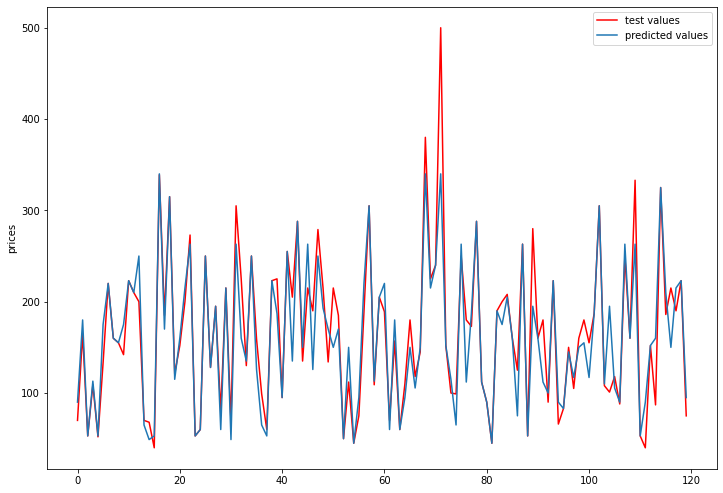

Prediction test visualization (ridge linear regressor): 


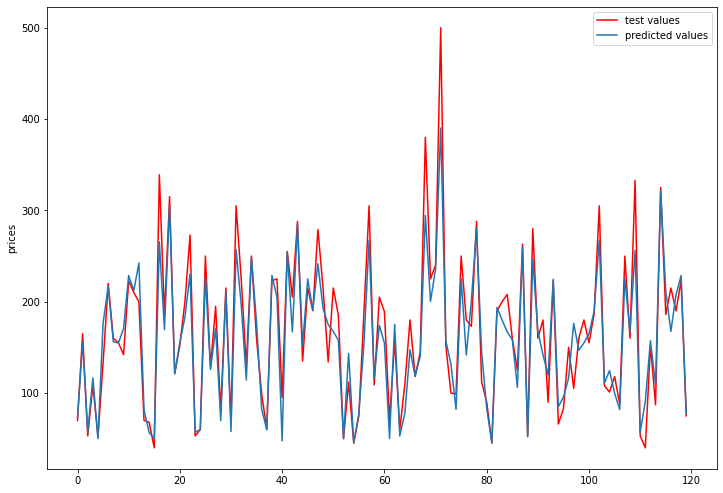

Prediction test visualization (AdaBoost regressor): 


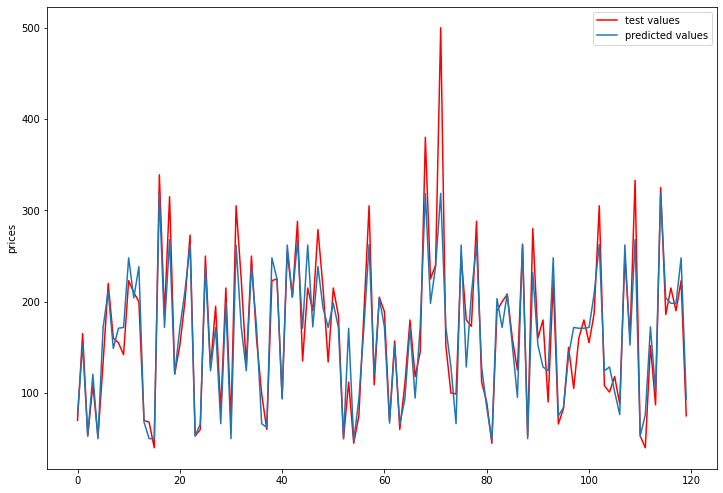

Prediction test visualization (Random Forest regressor): 


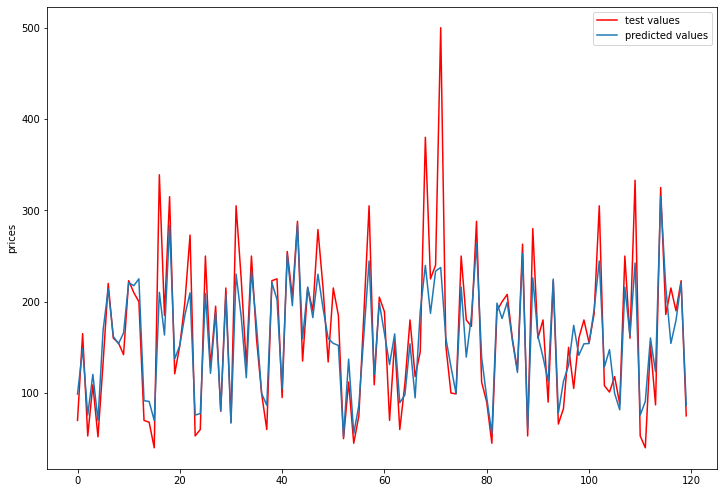

In [57]:
print("Prediction test visualization (tree model): ")
figure = plt.gcf()
figure.set_size_inches(12, 8.5)
plt.plot(y_test, color="r")
plt.plot(y_predicted)
plt.legend(['test values', 'predicted values'])
plt.ylabel("prices")
plt.show()

print("Prediction test visualization (ridge linear regressor): ")
figure = plt.gcf()
figure.set_size_inches(12, 8.5)
plt.plot(y_test, color="r")
plt.plot(ridge_y_predicted)
plt.legend(['test values', 'predicted values'])
plt.ylabel("prices")
plt.show()

print("Prediction test visualization (AdaBoost regressor): ")
figure = plt.gcf()
figure.set_size_inches(12, 8.5)
plt.plot(y_test, color="r")
plt.plot(ada_y_predicted)
plt.legend(['test values', 'predicted values'])
plt.ylabel("prices")
plt.show()


print("Prediction test visualization (Random Forest regressor): ")
figure = plt.gcf()
figure.set_size_inches(12, 8.5)
plt.plot(y_test, color="r")
plt.plot(rf_y_predicted)
plt.legend(['test values', 'predicted values'])
plt.ylabel("prices")
plt.show()
